<a href="https://colab.research.google.com/github/VGokulPillai/Knowledge-Graph-Implementation_Dissertation-/blob/main/Knowledge_Graph_using_DBpedia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install textacy
!pip install neomodel
!pip install folium==0.2.1
!pip install -U spacy
!python -m spacy download en

In [10]:
# Steps:
# 1. Forming subject - predicate - object triples. Use Dependency Parsing to do this. Try spaCy.
# 2. Optional: Make schema containing list of possible entities and relations
# 3. Entity recognition - Named Entity Recognition (NER) can be used for now.
# 4. Entity resolution: Map detected entities to DBpedia. http://www.gianlucademartini.net/kg/KGs-2-NER.pdf
# 5. Relation recognition
# Use falcon project for entitry and relation linking.
# Detected entities will have multiple mappings with DBpedia. Rank them on the basis of ??

import spacy
import textacy
import pandas as pd
import entityRecognitionLinking
import re

from difflib import SequenceMatcher
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()


import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')



from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline


def get_relation(sent):
    doc = nlp(sent)
    # Matcher class object 
    matcher = Matcher(nlp.vocab)

    #define the pattern 
    pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

    matcher.add("matching_1",[pattern])
    matches = matcher(doc)
    for match_id, start, end in matches:
      span = doc[start:end]  
      return(span.text)

def get_entities(sent):
    ## chunk 1
    ent1 = ""
    ent2 = ""

    prv_tok_dep = ""  # dependency tag of previous token in the sentence
    prv_tok_text = ""  # previous token in the sentence

    prefix = ""
    modifier = ""

    #############################################################

    for tok in nlp(sent):
        ## chunk 2
        # if token is a punctuation mark then move on to the next token
        if tok.dep_ != "punct":
            # check: token is a compound word or not
            if tok.dep_ == "compound":
                prefix = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    prefix = prv_tok_text + " " + tok.text

            # check: token is a modifier or not
            if tok.dep_.endswith("mod") == True:
                modifier = tok.text
                # if the previous word was also a 'compound' then add the current word to it
                if prv_tok_dep == "compound":
                    modifier = prv_tok_text + " " + tok.text

            ## chunk 3
            if tok.dep_.find("subj") == True:
                ent1 = modifier + " " + prefix + " " + tok.text
                prefix = ""
                modifier = ""
                prv_tok_dep = ""
                prv_tok_text = ""

                ## chunk 4
            if tok.dep_.find("obj") == True:
                ent2 = modifier + " " + prefix + " " + tok.text

            ## chunk 5  
            # update variables
            prv_tok_dep = tok.dep_
            prv_tok_text = tok.text
    #############################################################

    return [ent1.strip(), ent2.strip()]

In [15]:
candidate_sentences = pd.read_csv("/content/music_related_sents.csv")

# **DBpedia Extraction and Similarity checks**

In [16]:
entity_pairs = []
relations = []
entityLinkTriples = []
main_subject =[]


for inputText in tqdm(candidate_sentences["sentence"]):

  entity_pairs.append(get_entities(inputText))
  relations.append(get_relation(inputText))
  #Removing Unwanted things
  inputText = re.sub(r'\.(?=[^ \W\d])','.,', inputText)

  # Step 1: Knowledge Extraction. Output: SOP triples
  text = nlp(inputText)
  sop_list = textacy.extract.subject_verb_object_triples(text)

  #list_sop = sop_list.as_doc()
  sop_list_strings = []
  for sop in sop_list:
    temp = []
    sop0 = ' '.join(map(str,sop[0]))
    temp.append(sop0.lower())
    sop1 = ' '.join(map(str,sop[1]))
    temp.append(sop1.lower())
    sop2 = ' '.join(map(str,sop[2]))
    temp.append(sop2.lower())
    sop_list_strings.append(temp)



  # Step 2: Entity recognition and linking. This step needs to be linked.
  entityRecognitionLinkingObj = entityRecognitionLinking.EntityRecognitionLinking()
  entityRelJson = entityRecognitionLinkingObj.entityRecogLink(inputText)

  tempTriple_entities = ['', '', '']
  for resource in entityRelJson['Resources']:
    for entities in entity_pairs:
      for relation in relations:
        ratio_0 = similar(resource['@surfaceForm'].lower(),entities[0].lower())
        if ratio_0 > 0.5:
          tempTriple_entities[0] = resource['@surfaceForm']
        ratio_2 = similar(resource['@surfaceForm'].lower(),entities[1].lower())
        if ratio_2 > 0.5:
          tempTriple_entities[2] = resource['@surfaceForm']

        doc = nlp(resource['@surfaceForm'])
        for token in doc:
          if token.tag_ == 'VBN':
            if resource['@surfaceForm']!= relation:
              tempTriple_entities[1] = resource['@surfaceForm']
              relations.append(resource['@surfaceForm'])
            else:
              tempTriple_entities[1] = relation
          else:
            tempTriple_entities[1] = relation

    entityLinkTriples.append(tempTriple_entities)

      

    
  # Directly from DBpedia 
  tempTriple = ['', '', '']
  for sop in sop_list_strings:
    for resource in entityRelJson['Resources']:
      ratio0 = similar(resource['@surfaceForm'].lower(),sop[0].lower())
      if  ratio0 > 0.55:
        tempTriple[0] = resource['@surfaceForm']
    
      ratio1 = similar(resource['@surfaceForm'].lower(),sop[1].lower())
      if ratio1 > 0.55:
        tempTriple[1] = resource['@surfaceForm']

      ratio2 = similar(resource['@surfaceForm'].lower(),sop[2].lower())
      if ratio2 > 0.55:
        tempTriple[2] = resource['@surfaceForm']
    entityLinkTriples.append(tempTriple)

 11%|█         | 1/9 [00:00<00:01,  4.86it/s]

{
    "@confidence": "0.1",
    "@policy": "whitelist",
    "@sparql": "",
    "@support": "0",
    "@text": ".,The Beatles sign their first and only management contract with Brian Epstein at the managers offices at 12 Whitechapel St. in Liverpool. Epstein is to receive a full one-quarter of the bands earnings, yet to prove his worth, Epstein does not sign the contract until the following October.",
    "@types": "",
    "Resources": [
        {
            "@URI": "http://dbpedia.org/resource/The_Beatles",
            "@offset": "2",
            "@percentageOfSecondRank": "7.514208790815957E-6",
            "@similarityScore": "0.9999924851319262",
            "@support": "26047",
            "@surfaceForm": "The Beatles",
            "@types": "Wikidata:Q43229,Wikidata:Q24229398,Wikidata:Q215380,DUL:SocialPerson,DUL:Agent,Schema:Organization,Schema:MusicGroup,DBpedia:Organisation,DBpedia:Group,DBpedia:Agent,DBpedia:Band"
        },
        {
            "@URI": "http://dbpedia.org/re

 22%|██▏       | 2/9 [00:00<00:03,  2.10it/s]

{
    "@confidence": "0.1",
    "@policy": "whitelist",
    "@sparql": "",
    "@support": "0",
    "@text": "Mark Knopfler announces that Dire Straits has disbanded. He re-forms the group in 1991.",
    "@types": "",
    "Resources": [
        {
            "@URI": "http://dbpedia.org/resource/Mark_Knopfler",
            "@offset": "0",
            "@percentageOfSecondRank": "0.0",
            "@similarityScore": "1.0",
            "@support": "1246",
            "@surfaceForm": "Mark Knopfler",
            "@types": "Http://xmlns.com/foaf/0.1/Person,Wikidata:Q5,Wikidata:Q483501,Wikidata:Q24229398,Wikidata:Q215627,DUL:NaturalPerson,DUL:Agent,Schema:Person,Schema:MusicGroup,DBpedia:Person,DBpedia:Artist,DBpedia:Agent,DBpedia:MusicalArtist"
        },
        {
            "@URI": "http://dbpedia.org/resource/Restatement_of_Policy_on_Germany",
            "@offset": "14",
            "@percentageOfSecondRank": "0.6291714039918779",
            "@similarityScore": "0.5181308759153389",
 

 33%|███▎      | 3/9 [00:01<00:03,  1.74it/s]

{
    "@confidence": "0.1",
    "@policy": "whitelist",
    "@sparql": "",
    "@support": "0",
    "@text": "Weezer Frontman Rivers Cuomo wrote this song for and about Jamie Young, the bands first lawyer",
    "@types": "",
    "Resources": [
        {
            "@URI": "http://dbpedia.org/resource/Weezer",
            "@offset": "0",
            "@percentageOfSecondRank": "2.322442316205185E-13",
            "@similarityScore": "0.9999999999996447",
            "@support": "1916",
            "@surfaceForm": "Weezer",
            "@types": "Wikidata:Q43229,Wikidata:Q24229398,Wikidata:Q215380,DUL:SocialPerson,DUL:Agent,Schema:Organization,Schema:MusicGroup,DBpedia:Organisation,DBpedia:Group,DBpedia:Agent,DBpedia:Band"
        },
        {
            "@URI": "http://dbpedia.org/resource/Lead_vocalist",
            "@offset": "7",
            "@percentageOfSecondRank": "0.0",
            "@similarityScore": "0.999999999974122",
            "@support": "13224",
            "@surfaceFo

 44%|████▍     | 4/9 [00:02<00:03,  1.35it/s]

{
    "@confidence": "0.1",
    "@policy": "whitelist",
    "@sparql": "",
    "@support": "0",
    "@text": "The Beatles, who are filming an appearance on the show Thank Your Lucky Stars at a nearby studio, stop by the Crawdaddy Club in Richmond, England, where the upstart The Rolling Stones are performing. The bands meet for the first time backstage and hang out that evening.",
    "@types": "",
    "Resources": [
        {
            "@URI": "http://dbpedia.org/resource/The_Beatles",
            "@offset": "0",
            "@percentageOfSecondRank": "4.140754466926992E-9",
            "@similarityScore": "0.9999999958442345",
            "@support": "26047",
            "@surfaceForm": "The Beatles",
            "@types": "Wikidata:Q43229,Wikidata:Q24229398,Wikidata:Q215380,DUL:SocialPerson,DUL:Agent,Schema:Organization,Schema:MusicGroup,DBpedia:Organisation,DBpedia:Group,DBpedia:Agent,DBpedia:Band"
        },
        {
            "@URI": "http://dbpedia.org/resource/Thank_Your_Lu

 56%|█████▌    | 5/9 [00:04<00:05,  1.31s/it]

{
    "@confidence": "0.1",
    "@policy": "whitelist",
    "@sparql": "",
    "@support": "0",
    "@text": "The Beatles play The Cavern Club in Liverpool for the last time. They played the first of their 292 shows there in 1961 when they made their debut performance.",
    "@types": "",
    "Resources": [
        {
            "@URI": "http://dbpedia.org/resource/The_Beatles",
            "@offset": "0",
            "@percentageOfSecondRank": "1.9746595219722517E-4",
            "@similarityScore": "0.9998025544444777",
            "@support": "26047",
            "@surfaceForm": "The Beatles",
            "@types": "Wikidata:Q43229,Wikidata:Q24229398,Wikidata:Q215380,DUL:SocialPerson,DUL:Agent,Schema:Organization,Schema:MusicGroup,DBpedia:Organisation,DBpedia:Group,DBpedia:Agent,DBpedia:Band"
        },
        {
            "@URI": "http://dbpedia.org/resource/Play_(theatre)",
            "@offset": "12",
            "@percentageOfSecondRank": "0.3499321653497312",
            "@si

 67%|██████▋   | 6/9 [00:07<00:05,  1.69s/it]

{
    "@confidence": "0.1",
    "@policy": "whitelist",
    "@sparql": "",
    "@support": "0",
    "@text": "The Beatles release their second studio album, With The Beatles.",
    "@types": "",
    "Resources": [
        {
            "@URI": "http://dbpedia.org/resource/The_Beatles",
            "@offset": "0",
            "@percentageOfSecondRank": "1.238743555549103E-6",
            "@similarityScore": "0.9999982451729372",
            "@support": "26047",
            "@surfaceForm": "The Beatles",
            "@types": "Wikidata:Q43229,Wikidata:Q24229398,Wikidata:Q215380,DUL:SocialPerson,DUL:Agent,Schema:Organization,Schema:MusicGroup,DBpedia:Organisation,DBpedia:Group,DBpedia:Agent,DBpedia:Band"
        },
        {
            "@URI": "http://dbpedia.org/resource/Art_release",
            "@offset": "12",
            "@percentageOfSecondRank": "0.5320000101518672",
            "@similarityScore": "0.6332918182636961",
            "@support": "290",
            "@surfaceForm": "r

 78%|███████▊  | 7/9 [00:08<00:03,  1.61s/it]

{
    "@confidence": "0.1",
    "@policy": "whitelist",
    "@sparql": "",
    "@support": "0",
    "@text": ".,When The Beatles play The Royal Variety Performance in London in front of an audience that includes the Queen Mother and Princess Margaret, John Lennon says, \"Will the people in the cheaper seats clap your hands. All the rest of you, rattle your jewelry.\"",
    "@types": "",
    "Resources": [
        {
            "@URI": "http://dbpedia.org/resource/The_Beatles",
            "@offset": "7",
            "@percentageOfSecondRank": "4.1378267643119187E-7",
            "@similarityScore": "0.9999995860747792",
            "@support": "26047",
            "@surfaceForm": "The Beatles",
            "@types": "Wikidata:Q43229,Wikidata:Q24229398,Wikidata:Q215380,DUL:SocialPerson,DUL:Agent,Schema:Organization,Schema:MusicGroup,DBpedia:Organisation,DBpedia:Group,DBpedia:Agent,DBpedia:Band"
        },
        {
            "@URI": "http://dbpedia.org/resource/Theatre",
            "

 89%|████████▉ | 8/9 [00:14<00:03,  3.03s/it]

{
    "@confidence": "0.1",
    "@policy": "whitelist",
    "@sparql": "",
    "@support": "0",
    "@text": "The magazine The New Yorker publishes an interview with Beatles manager Brian Epstein in their \"Talk Of The Town\" column about the bands upcoming Ed Sullivan gig - the first major press the group has received in the US.",
    "@types": "",
    "Resources": [
        {
            "@URI": "http://dbpedia.org/resource/The_Guardian",
            "@offset": "0",
            "@percentageOfSecondRank": "0.6164368690241712",
            "@similarityScore": "0.5635180959404135",
            "@support": "48197",
            "@surfaceForm": "The",
            "@types": "Wikidata:Q386724,Wikidata:Q234460,Wikidata:Q11032,Wikidata:Q1092563,Schema:CreativeWork,DBpedia:WrittenWork,DBpedia:Work,DBpedia:PeriodicalLiterature,DBpedia:Newspaper"
        },
        {
            "@URI": "http://dbpedia.org/resource/Magazine",
            "@offset": "4",
            "@percentageOfSecondRank": "2.1

100%|██████████| 9/9 [00:21<00:00,  2.44s/it]


In [17]:
print(entityLinkTriples)
kg_df = pd.DataFrame(entityLinkTriples)
kg_df = kg_df.drop_duplicates()
kg_df.rename(columns = {0:'source', 1:'edge',2:'target'}, inplace = True)
kg_df.to_csv('kg_main_DBpedia.csv')

[['Epstein', '.The', 'October'], ['Epstein', '.The', 'October'], ['Epstein', '.The', 'October'], ['Epstein', '.The', 'October'], ['Epstein', '.The', 'October'], ['Epstein', '.The', 'October'], ['Epstein', '.The', 'October'], ['Epstein', '.The', 'October'], ['Epstein', '.The', 'October'], ['Epstein', '.The', 'October'], ['Epstein', '.The', 'October'], ['Epstein', '.The', 'October'], ['Epstein', '.The', 'October'], ['Epstein', '.The', 'October'], ['Epstein', '.The', 'October'], ['Epstein', '.The', 'October'], ['Epstein', '.The', 'October'], ['Epstein', '.The', 'October'], ['Epstein', 'sign', 'contract'], ['Epstein', 'sign', 'contract'], ['', 'broken', ''], ['', 'broken', ''], ['', 'broken', ''], ['', 'broken', ''], ['', 'broken', ''], ['', 'broken', ''], ['', 'broken', ''], ['', 'broken', ''], ['', 'broken', ''], ['Stephen Malkmus', '', ''], ['He', 'announces', '1991'], ['He', 'announces', '1991'], ['He', 'announces', '1991'], ['He', 'announces', '1991'], ['He', 'announces', '1991'], ['H

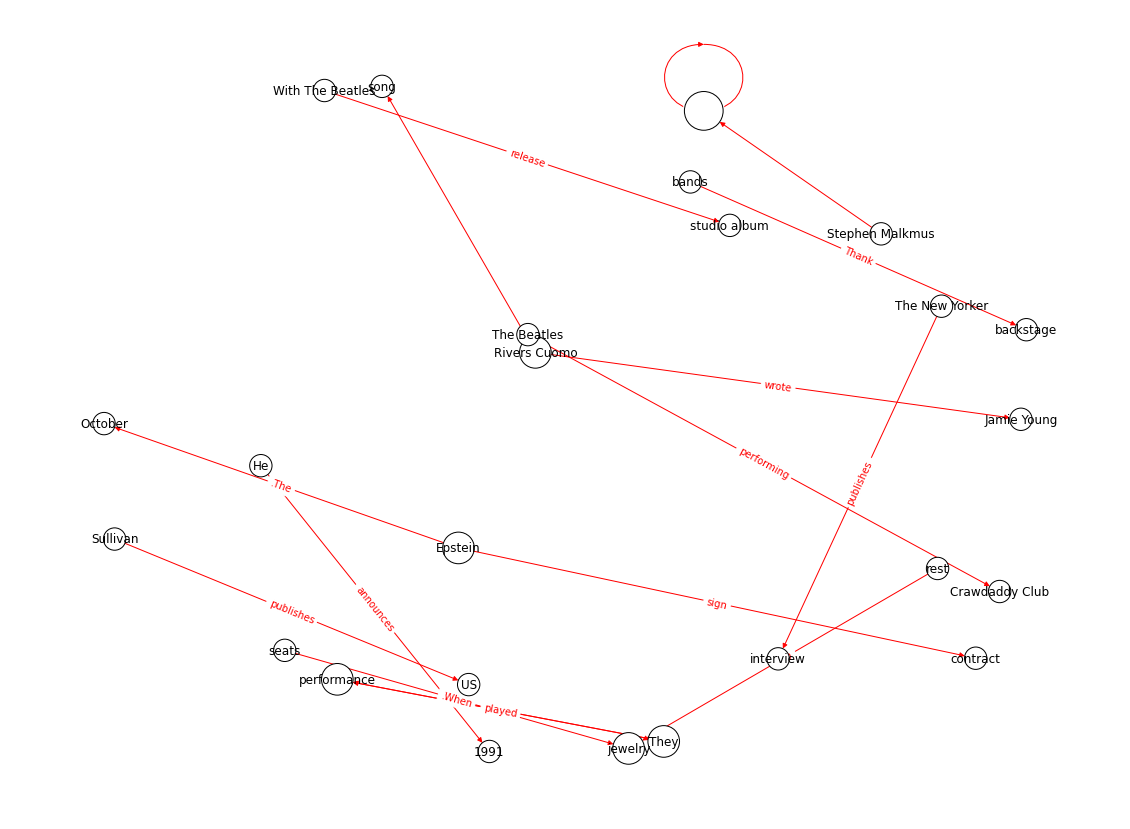

In [18]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_kg_v2(pairs):
    k_graph = nx.from_pandas_edgelist(pairs, 'source', 'target',create_using=nx.MultiDiGraph())
    node_deg = nx.degree(k_graph)
    layout = nx.spring_layout(k_graph, k=0.5, iterations=20)
    plt.figure(figsize=(20,15))
    nx.draw_networkx(
        k_graph,
        node_size=[int(deg[1]) * 500 for deg in node_deg],
        pos=layout,
        edge_color='red',
        edgecolors='black',
        node_color='white',
        )
    labels = dict(zip(list(zip(pairs.source, pairs.target)),pairs['edge'].tolist()))
    nx.draw_networkx_edge_labels(k_graph, pos=layout, edge_labels=labels,font_color='red')
    plt.axis('off')
    plt.show()
draw_kg_v2(kg_df)